In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import pickle as pkl
import sys 
sys.path.append("../models/") 
from functions import plot_style
from Basin import Basin
import numpy as np
from datetime import datetime, timedelta
colors = plot_style("../fonts/Encode_Sans_Condensed/")
import warnings
warnings.filterwarnings("ignore")

countries = np.array(['Indonesia', 'Bolivia', 'Morocco', 'Bangladesh', 'Sri Lanka', 'Kenya', 'Mozambique',
                      "Afghanistan", "Pakistan", "El Salvador", 
                      "Philippines", "Uganda", "Kyrgyzstan", "Egypt", "Rwanda", "Zambia", "Angola", "Ghana", "Honduras", "Côte d'Ivoire"])

# dates
start_date = datetime(2020, 12, 1)
end_date = datetime(2021, 10, 1)
dates = [start_date + timedelta(days=d) for d in range((end_date - start_date).days)]

npis = np.arange(0.05, 1.0, 0.05)
weeks = np.arange(4, 44, 4)

# import data 
with open("./output_npis_october/averted_deaths_npis.pkl", "rb") as file:
    averted_deaths = pkl.load(file)

with open("./output_npis_october/averted_deaths_npis_CI.pkl", "rb") as file:
    averted_deaths_CI = pkl.load(file)

def get_npis_levels(weeks_idx):
    npis_levels = []
    for country in countries:
        level_us = averted_deaths[country]["us_rescale"]
        npis_levels.append(100 * npis[np.argmin(np.abs(averted_deaths[country]["npis"][:, weeks_idx] - level_us))])
    return npis_levels


../models/functions.py:286: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [2]:
weeks_idx = 3

npis_levels_med, npis_levels_q1, npis_levels_q2 = [], [], []
percVax = []
for country in countries:

    basin = Basin(country, "../basins/")
    percVax.append(basin.vaccinations.loc[basin.vaccinations.Day == end_date].people_fully_vaccinated_per_hundred.values[0])
    
    npis_levels = []
    for i in range(1000):
        npis_levels.append(100 * npis[np.argmin(np.abs(averted_deaths_CI[country]["npis"][:, weeks_idx][:, i] - averted_deaths_CI[country]["us_rescale"][i]))])

    npis_levels_med.append(np.quantile(npis_levels, q=0.5))
    npis_levels_q1.append(np.quantile(npis_levels, q=0.25))
    npis_levels_q2.append(np.quantile(npis_levels, q=0.75))

In [3]:
def point_plot(ax, pos, med, color, marker):
    ax.scatter([pos], [med], color=color, s=100, edgecolor='white', linewidth=0.7, zorder=1, marker=marker)


def plot_bar(ax, pos, med, q1, q2, color, marker):
    ax.scatter([pos], [med], color=color, s=100, edgecolor='white', linewidth=0.7, zorder=1, marker=marker)
    ax.plot([pos, pos], [q1, q2], color=color, solid_capstyle='round', linewidth=8, alpha=0.5, zorder=-1)


def scatter_plot(ax, npis_levels_med, npis_levels_q1, npis_levels_q2):

    # plot  
    idx = np.argsort(npis_levels_med)#[::-1]

    for i in range(len(idx)):
        #point_plot(ax, i, npis_levels[idx[i]], colors[0], "o")
        plot_bar(ax, i, npis_levels_med[idx[i]], npis_levels_q1[idx[i]], npis_levels_q2[idx[i]], colors[0], "o")

    ax.set_xticks(range(len(idx)))
    ax.set_xticklabels(countries[idx], rotation=90, size=8)
    ax.set_ylabel("Additional NPIs (%)",  fontsize=8)

    ax.set_title("Additional NPIs needed to offset lack of vaccines", weight="bold")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.yaxis.grid(True, color='grey', linewidth=0.1, zorder=-1, linestyle="--")
    ax.set_axisbelow(True)
    ax.tick_params(axis="y", labelsize=8)

    #plt.savefig("./img/" + file_name + ".pdf", bbox_inches="tight")


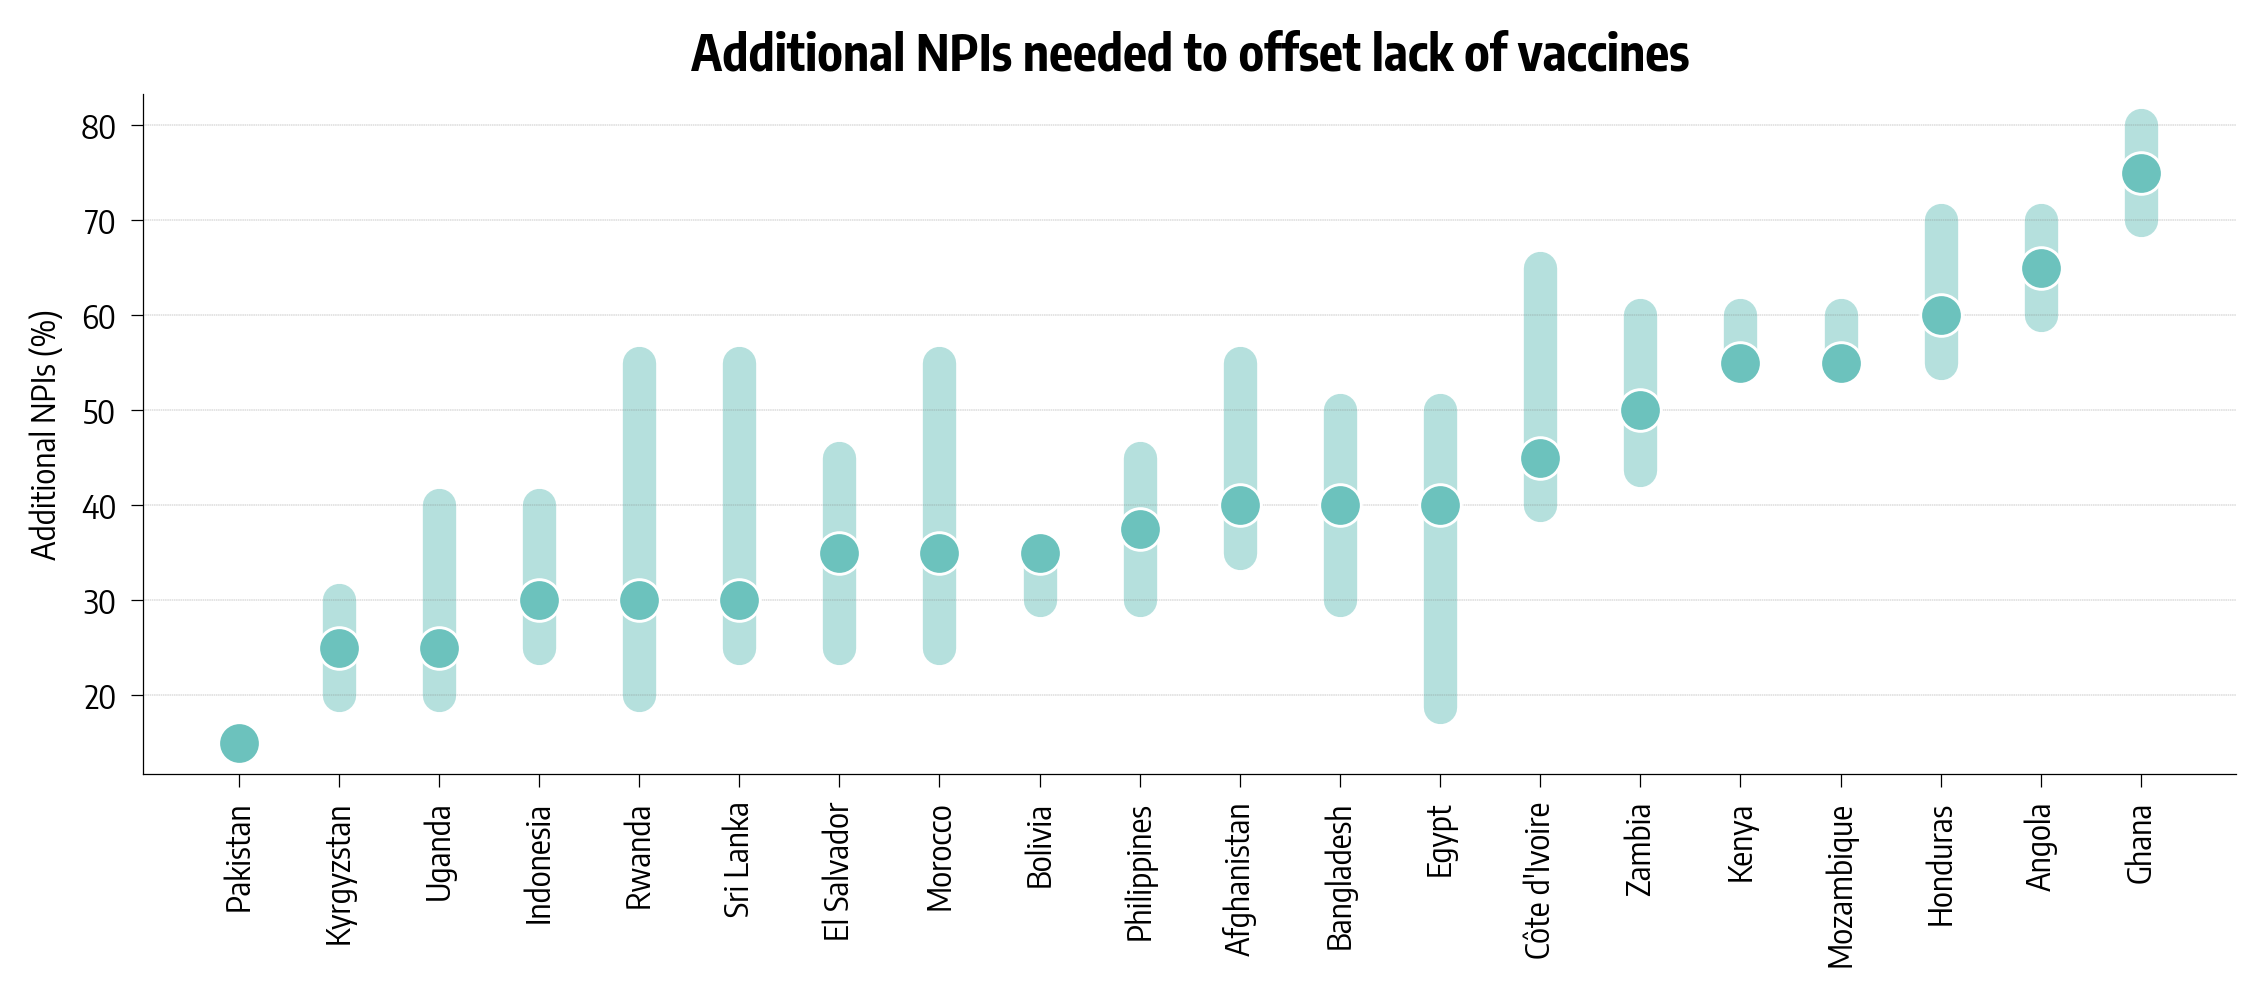

In [4]:
fig, ax = plt.subplots(dpi=300, figsize=(9,3))

npis_levels = get_npis_levels(weeks_idx=3)
scatter_plot(ax, npis_levels_med, npis_levels_q1, npis_levels_q2)

plt.savefig("./img/additional_NPIs.pdf", bbox_inches='tight')


In [5]:
print('Additional NPIs needed')
print(f'Min: {np.min(npis_levels_med)}')
print(f'Max: {np.max(npis_levels_med)}')
print(f'Mean: {np.mean(npis_levels_med)}')
print(f'Median: {np.median(npis_levels_med)}')

Additional NPIs needed
Min: 15.000000000000002
Max: 75.00000000000001
Mean: 41.125
Median: 38.75


In [15]:
averted_deaths['Ghana']["npis"].min()

-7.5277392984467

Pakistan: 75.1559177075874


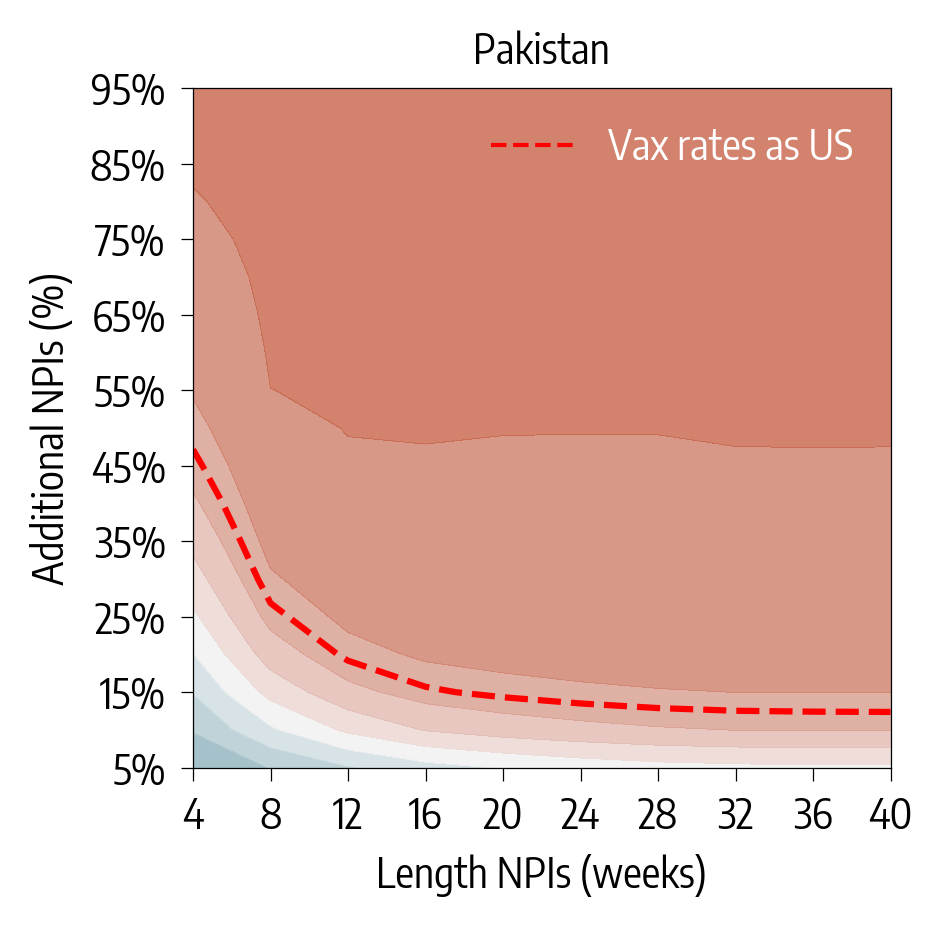

In [16]:
def plot_contourf(ax, country, legend=True):
    
    level_us = averted_deaths[country]["us_rescale"]     
    im = ax.contourf(averted_deaths[country]["npis"], origin='lower', interpolation="gaussian", extend="neither",
                levels=np.arange(-10, 110, 10), alpha=0.8, 
                vmin=-10, vmax=100, cmap=sns.diverging_palette(220, 20, as_cmap=True))
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    
    print("{0}: {1}".format(country, level_us))
    ax.contour(averted_deaths[country]["npis"], levels=[level_us], interpolation="gaussian", linestyles=['--'],
               colors=["red"], extent=[xmin, xmax, ymin, ymax], label="Deaths averted with US vax rates")


    #plt.colorbar(im)

    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    ax.set_xticks(0.5 + np.arange(0,len(weeks)))
    ax.set_yticks(0.5 + np.arange(0,len(npis),2))
    ax.set_xticklabels([str(d) for d in weeks], fontsize=10);
    ax.set_yticklabels([str(int(100 * npis[i])) + "%" for i in np.arange(0,len(npis),2)], fontsize=10)
    ax.set_title(country, fontsize=10)

    ax.set_xlabel("Length NPIs (weeks)")
    ax.set_ylabel("Additional NPIs (%)")

    if legend:
        custom_lines = [Line2D([0], [0], color="red", lw=1, linestyle="--")]
        l = ax.legend(custom_lines, ['Vax rates as US'], ncol=3, frameon=False)
        for text in l.get_texts():
            text.set_color("white")


fig, ax = plt.subplots(dpi=300, figsize=(3,3))
plot_contourf(ax, "Pakistan")
plt.savefig("./img/pakistan.pdf", bbox_inches="tight")


Philippines: 83.93019676112542


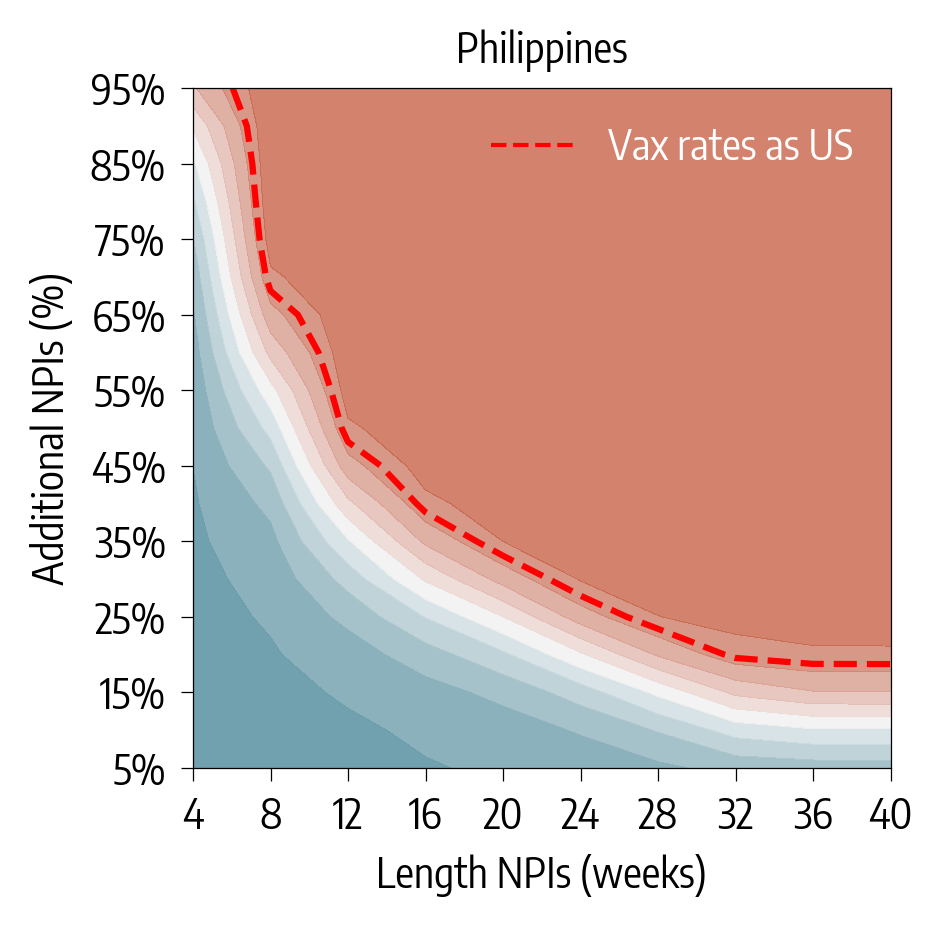

In [17]:
fig, ax = plt.subplots(dpi=300, figsize=(3,3))
plot_contourf(ax, "Philippines")
plt.savefig("./img/philippines.pdf", bbox_inches="tight")

Ghana: 60.72473335304008


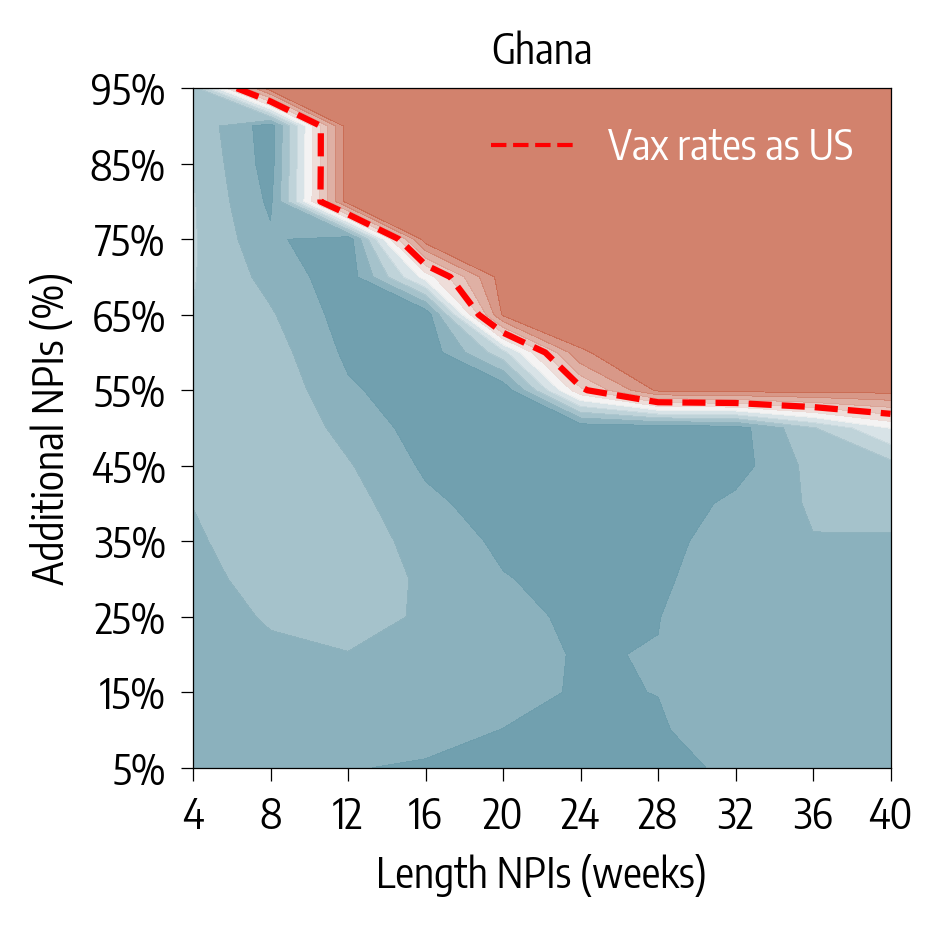

In [18]:
fig, ax = plt.subplots(dpi=300, figsize=(3,3))
plot_contourf(ax, "Ghana")
plt.savefig("./img/ghana.pdf", bbox_inches="tight")